<h2 style="color: #0074D9;">Table of Contents</h2>
<ol>
    <li><a href="#Data" style="font-size: larger; color: #0074D9; font-weight: bold;">Data Loading</a></li>
    <li><a href="#IntMatr" style="font-size: larger; color: #0074D9; font-weight: bold;">Interaction Matrix</a></li>
    <li><a href="#Split" style="font-size: larger; color: #0074D9; font-weight: bold;">Train/Test split</a></li>
    <li><a href="#Evaluation" style="font-size: larger; color: #0074D9; font-weight: bold;">Evaluation</a></li>
</ol>

In [1]:
#disabe annoying warnings
import warnings
warnings.filterwarnings('ignore')
#imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, coo_matrix , save_npz, load_npz, find
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
#utils
import evaluations as evals
import rec_sys as rs


<h1 style="color:rgb(0,120,170)">Dataset: MIND-small</h1>

------------------------------------------------------

<a id="Data"></a>

entity_embedding.vec ->	The embeddings of **entities** in news extracted from knowledge graph (Nodes) <br>
relation_embedding.vec	->  The embeddings of **relations** between entities extracted from knowledge graph (Edges)<br>
both [ID (retrievable from news dataset: columns) - EMB VALUES]

In [23]:
news = 'MINDsmall_train/news.tsv'
behavior = 'MINDsmall_train/behaviors.tsv'
def load_news_df(path):
    if 'news' in path:
        columns = ['News ID',
                "Category",
                "SubCategory",
                "Title",
                "Abstract",
                "URL",
                "Title Entities",
                "Abstract Entities"]
    
    elif 'behavior' in path:
        columns = ['Impression ID',
                "User ID",
                "Time",
                "History",
                "Impressions"]
    
    df = pd.read_csv(path, sep='\t', header=None, names=columns)
    return df

In [24]:
#load data
news, behavior = load_news_df(news), load_news_df(behavior)
binary_interaction_matrix = load_npz('binary_interaction_matrix_15.npz')
nclick_interaction_matrix = load_npz('n_click_interaction_matrix_15.npz')
#print(news.shape) # --->(51282, 8)
#print(behavior.shape)#--->(156965, 5)
#""" @TO-DO (possibly): use only news with category = 'news' & subcategory = 'newspolitics' """
#news = news[(news['Category'] == 'news') & (news['SubCategory'] == 'newspolitics')] #--->(2826, 8) -> troppe poche?



<h1 style="color:rgb(0,120,170)">Interaction Matrix</h1>

------------------------------------------------------

<a id="IntMatr"></a>
every item interacted with at least 15 times & every user has at least 15 interactions<br>
https://www.sciencedirect.com/science/article/abs/pii/S0957417423023771 <br>
http://yifanhu.net/PUB/cf.pdf


### Interaction Matrix with 1 and 0 (Binary Indicators)

*   **Pros**:
    
    *   **Simplicity**: It's straightforward to interpret and implement. An entry of 1 simply means interaction occurred, and 0 means it did not.
    *   **Consistency**: Each interaction is treated equally, which can be appropriate when the mere presence of an interaction is more important than its frequency.
    *   **Scalability**: For very large datasets, binary matrices might be more memory-efficient, especially when using sparse matrix representations.
*   **Cons**:
    
    *   **Loss of Information**: It doesn't capture the depth of user engagement, such as repeated interactions with the same item, which could indicate stronger preferences.

### Interaction Matrix with Number of Clicks (N)

*   **Pros**:
    
    *   **Rich Information**: Captures not just the occurrence of interactions but their frequency, offering insights into user preferences and engagement levels.
    *   **Personalization**: Enables more nuanced recommendations by distinguishing between casual and highly interested interactions.
*   **Cons**:
    
    *   **Complexity**: Handling and interpreting the data becomes more complicated, especially in terms of recommendation algorithms that need to account for varying interaction levels.
    *   **Normalization Issues**: Raw interaction counts may need to be normalized to prevent popular items from dominating recommendations purely due to higher visibility rather than genuine user interest.

# Binary

In [ ]:
#initialize interaction matrix shape (users, news)
interaction_matrix_small = pd.DataFrame(0, index=behavior['User ID'].unique(), columns=news['News ID'].unique(), dtype='int16')

#NEXT: populate it using both history and impressions<br><br>
**Q: binary coding (1,0) vs ternary coding (1,0,-1)** ? <br>
PRO (TERNARY): deeplearning algo leverage negative feedback efficiently<br>
CONTRO: More complex, possible noise (non click != non interest, is not given)

In [ ]:
behavior["History"] = behavior["History"].apply(lambda x: x.split(" ") if isinstance(x, str) else [])#make it iterable
behavior["Impressions"] = behavior["Impressions"].apply(lambda x: x.split(" ") if isinstance(x, str) else [])

updates = {}

for index, row in behavior.iterrows():
    user_id = row['User ID']
    
    #binary encoding to populate matrix
    for news_id in row['History']:                          #w/ history
        if news_id in interaction_matrix_small.columns:
            updates[(user_id, news_id)] = 1
            
    
    for impression in row['Impressions']:                   #w/ impression
        news_id, clicked = impression.split('-')
        if clicked == '1' and news_id in interaction_matrix_small.columns:
            updates[(user_id, news_id)] = 1

for (user_id, news_id), value in updates.items():
    interaction_matrix_small.at[user_id, news_id] = value
    
interaction_matrix_small = interaction_matrix_small.astype('int8') #it's just 1 and 0
#interaction_matrix_small.iloc[:10, :10]

In [ ]:
print(f'interaction_matrix before: {interaction_matrix_small.shape}')
interaction_matrix_filtered = interaction_matrix_small.copy()

continue_filtering = True
while continue_filtering:
    #keep only news clicked by min 5 users
    cols_to_keep = interaction_matrix_filtered.columns[interaction_matrix_filtered.sum(axis=0) >= 15]
    interaction_matrix_filtered = interaction_matrix_filtered[cols_to_keep]
    
    #keep only users that clicked min 5 news
    rows_to_keep = interaction_matrix_filtered.index[interaction_matrix_filtered.sum(axis=1) >= 15]
    interaction_matrix_filtered = interaction_matrix_filtered.loc[rows_to_keep]
    
    #stop criteria
    min_int_per_user = interaction_matrix_filtered.sum(axis=1).min()
    min_int_per_news = interaction_matrix_filtered.sum(axis=0).min()
    if min_int_per_user >= 15 and min_int_per_news >= 15:
        continue_filtering = False


In [3]:
#sanity check
interaction_matrix_filtered = load_npz('binary_interaction_matrix_15.npz')
print(f'interaction_matrix after: {interaction_matrix_filtered.shape}')
print("min int per user:", interaction_matrix_filtered.sum(axis=1).min())
print("min int per news:", interaction_matrix_filtered.sum(axis=0).min())
print("max int per user:", interaction_matrix_filtered.sum(axis=1).max())
print("max int per news:", interaction_matrix_filtered.sum(axis=0).max())

interaction_matrix after: (22093, 8858)
min int per user: 15
min int per news: 15
max int per user: 463
max int per news: 3254


In [ ]:
#all good let's save it
interaction_matrix_csr = csr_matrix(interaction_matrix_filtered.values)
print(interaction_matrix_csr.shape)
#save_npz('binary_interaction_matrix.npz', interaction_matrix_csr)

# N of clicks

In [ ]:
#initialize the  interaction matrix
interaction_matrix = pd.DataFrame(0, index=behavior['User ID'].unique(), columns=news['News ID'].unique(), dtype='int16') #max fill value is 310 (b4 normalization)
#populate matrix with implicit interactions
for index, row in behavior.iterrows():
    user_id = row["User ID"]
   
    if pd.notnull(row["History"]):              #w/ user history
        history_news_ids = row["History"].split()
        for news_id in history_news_ids:
            if news_id in interaction_matrix.columns:
                interaction_matrix.at[user_id, news_id] += 1           
    
    if pd.notnull(row["Impressions"]):          #w/ user impression
        impressions = row["Impressions"].split()
        for impression in impressions:
            news_id, clicked = impression.split('-')
            if news_id in interaction_matrix.columns and clicked == '1':  #MODIFY HERE: in case of ternary encoding (e.g. -1 for non-clicked)
                interaction_matrix.at[user_id, news_id] += 1

In [26]:
#bool mask
interaction_matrix_boolean = interaction_matrix.applymap(lambda x: x > 0)

continue_filtering = True
while continue_filtering:
    #keep only news clicked by min 5 users
    cols_to_keep = interaction_matrix_boolean.sum(axis=0) >= 15
    interaction_matrix_boolean = interaction_matrix_boolean.loc[:, cols_to_keep]

    #keep only users that clicked min 5 news
    rows_to_keep = interaction_matrix_boolean.sum(axis=1) >= 15
    interaction_matrix_boolean = interaction_matrix_boolean.loc[rows_to_keep, :]

    #stop criteria
    min_int_per_user = interaction_matrix_boolean.sum(axis=1).min()
    min_int_per_news = interaction_matrix_boolean.sum(axis=0).min()
    if min_int_per_user < 15 or min_int_per_news < 15:
        continue_filtering = True
    else:
        continue_filtering = False

#filter with mask
interaction_matrix_filtered = interaction_matrix.loc[interaction_matrix_boolean.index, interaction_matrix_boolean.columns]


In [ ]:
interaction_matrix_filtered = load_npz('n_click_interaction_matrix_15.npz')
print("min int per user:", (interaction_matrix_filtered > 0).sum(axis=1).min())
print("min int per news:", (interaction_matrix_filtered > 0).sum(axis=0).min())
print("max int per user:", interaction_matrix_filtered.sum(axis=1).max())
print("max int per news:", interaction_matrix_filtered.sum(axis=0).max())
print('after:', interaction_matrix_filtered.shape)

In [30]:
interaction_matrix_csr = csr_matrix(interaction_matrix_filtered.values)
print(interaction_matrix_csr.shape)
#save_npz('n_click_interaction_matrix.npz', interaction_matrix_csr)

(46594, 15471)


**NORMALIZATION**

long tail distrib: most news receive only a few clicks, very small number receive many clicks.---> Log scaling (add+1 so no prob with zero clicks) + normalization (so can handle e.g. svm and knn)<br><br>
*minmax & z-score give the same plot just different range on x values (?)---->problematic bc no interaction = 0*<br>
MaxAbsScaler preferred with sparse data


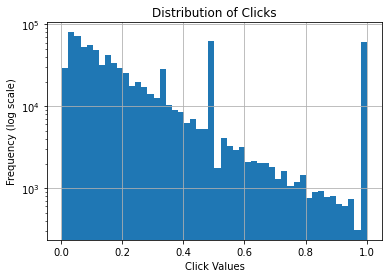

In [20]:
#normalize data
nclick_interaction_matrix = load_npz('n_click_interaction_matrix_15.npz')
nclick_interaction_matrix = MaxAbsScaler().fit_transform(nclick_interaction_matrix)
#plot
non_zero_clicks = nclick_interaction_matrix.data 
plt.hist(non_zero_clicks, bins=50, log=True) #visualize tail too
plt.title('Distribution of Clicks')
plt.xlabel('Click Values')
plt.ylabel('Frequency (log scale)')
plt.grid(True)
plt.show()

In [21]:
#save normalized data
save_npz('n_click_interaction_matrix_15.npz', nclick_interaction_matrix)


<h1 style="color:rgb(0,120,170)">Train/Test split</h1>

------------------------------------------------------

<a id="Split"></a>
stratified split ensure both train and test have instance for the same users: imp bc avoid cold start problem

In [25]:
bin_interaction_matrix_csr = load_npz('binary_interaction_matrix_15.npz')
n_interaction_martrix_csr = load_npz('n_click_interaction_matrix_15.npz')
assert np.array_equal(bin_interaction_matrix_csr.shape, n_interaction_martrix_csr.shape), "shape mismatch!!"

## BINARY

In [50]:
#BINARY
users, items = bin_interaction_matrix_csr.nonzero()
interactions = list(zip(users, items))
interactions_by_user = {}                   # {user: [item1, item2, ...]}
for user, item in interactions:
    if user not in interactions_by_user:
        interactions_by_user[user] = []
    interactions_by_user[user].append(item)


def stratified_train_test_split(interactions_by_user, test_size=0.2):
    train_interactions = []
    test_interactions = []

    for user, items in interactions_by_user.items():
        np.random.shuffle(items)
        n_test = max(int(len(items) * test_size), 1)  # at least 1 item for the test set
        n_train = len(items) - n_test

        items_train = items[:n_train]
        items_test = items[n_train:]

        train_interactions.extend([(user, item) for item in items_train])
        test_interactions.extend([(user, item) for item in items_test])

    return train_interactions, test_interactions


def create_sparse_matrix(interactions, shape):
    row, col = zip(*interactions)
    data = np.ones(len(interactions))
    return coo_matrix((data, (row, col)), shape=shape)

#split
train_interactions, test_interactions = stratified_train_test_split(interactions_by_user, test_size=0.2)
#put back into matrices
train_matrix = create_sparse_matrix(train_interactions, bin_interaction_matrix_csr.shape)
test_matrix = create_sparse_matrix(test_interactions, bin_interaction_matrix_csr.shape)
train_matrix, test_matrix = train_matrix.tocsr() , test_matrix.tocsr()
#looks good, save train and test matrices
#save_npz('b_train_matrix.npz', train_matrix)
#save_npz('b_test_matrix.npz', test_matrix)

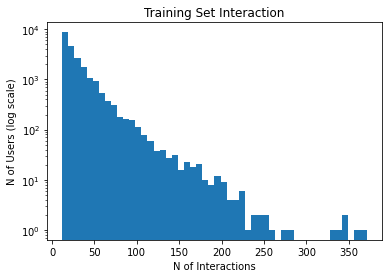

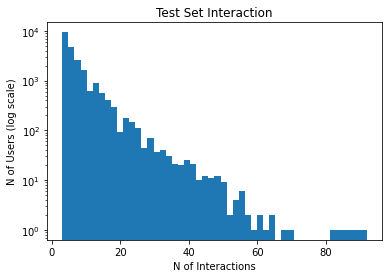

Training set sparsity: 0.9965797153572885
Test set sparsity: 0.9991980165293378


In [27]:
b_test_matrix = load_npz('b_test_matrix_15.npz')
b_train_matrix = load_npz('b_train_matrix_15.npz')
def plot_interactions_distribution(train_matrix, test_matrix):
    
    train_interactions_per_user = np.diff(train_matrix.indptr)
    test_interactions_per_user = np.diff(test_matrix.indptr)

    #train
    plt.hist(train_interactions_per_user, bins=50, log=True)
    plt.title('Training Set Interaction')
    plt.xlabel('N of Interactions')
    plt.ylabel('N of Users (log scale)')
    plt.show()
    #test
    plt.hist(test_interactions_per_user, bins=50, log=True)
    plt.title('Test Set Interaction')
    plt.xlabel('N of Interactions')
    plt.ylabel('N of Users (log scale)')
    plt.show()

#have a look at sparsity (should be very high)
def calculate_sparsity(matrix):
    total_possible_interactions = matrix.shape[0] * matrix.shape[1]
    actual_interactions = len(matrix.nonzero()[0])
    sparsity = 1 - (actual_interactions / total_possible_interactions)
    return sparsity


plot_interactions_distribution(b_train_matrix, b_test_matrix)
train_sparsity = calculate_sparsity(b_train_matrix)
test_sparsity = calculate_sparsity(b_test_matrix)
print("Training set sparsity:", train_sparsity)
print("Test set sparsity:", test_sparsity)


min=15 more sparse than min=5; very similar long tail distr-> expected

## N of clicks

In [ ]:
#N OF CLICKS
def create_train_test_sets_sparse(interaction_matrix, test_size=0.2):
    num_users, num_items = interaction_matrix.shape
    train_set = interaction_matrix.copy()
    test_set = csr_matrix(interaction_matrix.shape, dtype=np.float16) #max fillvalue is 310
    
    for user_id in range(num_users):
        user_interactions_indices = interaction_matrix[user_id].nonzero()[1]
        
        assert len(user_interactions_indices) > 0, f"user {user_id} has no interactions!!!"
        
        num_interactions = len(user_interactions_indices)
        num_test = max(1, int(np.ceil(test_size * num_interactions)))
        test_indices = np.random.choice(user_interactions_indices, size=num_test, replace=False)
        
        # Set values in test_set and remove those from train_set
        test_values = interaction_matrix[user_id, test_indices].toarray()
        test_set[user_id, test_indices] = test_values
        train_set[user_id, test_indices] = 0
    
    return train_set, test_set


train_set, test_set = create_train_test_sets_sparse(interaction_matrix)

print(f"train set: {train_set.shape}, non-zero elements: {train_set.nnz}")
print(f"test set: {test_set.shape}, non-zero elements: {test_set.nnz}")
train_set, test_set = train_set.tocsr(), test_set.tocsr()
save_npz('n_train_matrix_15.npz', train_set)
save_npz('n_test_matrix_15.npz', test_set)


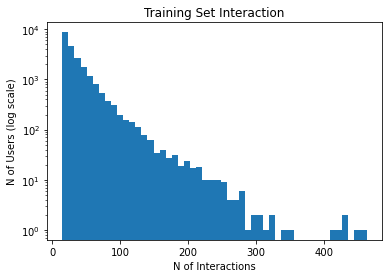

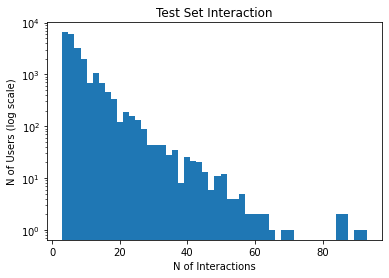

Training set sparsity: 0.9966668743657441
Test set sparsity: 0.9991108575208822


In [28]:
n_train_matrix = load_npz('n_train_matrix_15.npz')
n_test_matrix = load_npz('n_test_matrix_15.npz')
def plot_interactions_distribution(train_matrix, test_matrix):
    
    train_interactions_per_user = np.diff(train_matrix.indptr)
    test_interactions_per_user = np.diff(test_matrix.indptr)

    #train
    plt.hist(train_interactions_per_user, bins=50, log=True)
    plt.title('Training Set Interaction')
    plt.xlabel('N of Interactions')
    plt.ylabel('N of Users (log scale)')
    plt.show()
    #test
    plt.hist(test_interactions_per_user, bins=50, log=True)
    plt.title('Test Set Interaction')
    plt.xlabel('N of Interactions')
    plt.ylabel('N of Users (log scale)')
    plt.show()

#have a look at sparsity (should be very high)
def calculate_sparsity(matrix):
    total_possible_interactions = matrix.shape[0] * matrix.shape[1]
    actual_interactions = len(matrix.nonzero()[0])
    sparsity = 1 - (actual_interactions / total_possible_interactions)
    return sparsity


plot_interactions_distribution(n_train_matrix, n_test_matrix)
train_sparsity = calculate_sparsity(n_train_matrix)
test_sparsity = calculate_sparsity(n_test_matrix)
print("Training set sparsity:", train_sparsity)
print("Test set sparsity:", test_sparsity)


---------check 4 data leakage-----------

In [29]:
#small check if interaction matrices have data leakage via intersection of matrices
b_train_matrix = load_npz('b_train_matrix_15.npz')
b_test_matrix = load_npz('b_test_matrix_15.npz')
n_train_matrix = load_npz('n_train_matrix_15.npz')
n_test_matrix = load_npz('n_test_matrix_15.npz')

def check_data_leakage(train_matrix: csr_matrix, test_matrix: csr_matrix):   
    train_nonzero = set(zip(train_matrix.nonzero()[0], train_matrix.nonzero()[1])) #again in tuple form
    test_nonzero = set(zip(test_matrix.nonzero()[0], test_matrix.nonzero()[1]))
    common_elements = train_nonzero.intersection(test_nonzero)
    if common_elements:
        print(f"Data leakage: {len(common_elements)} interactions are in both sets.")
    else:
        print("All good!")
        
b_data_leakage = check_data_leakage(b_train_matrix, b_test_matrix)
n_data_leakage = check_data_leakage(n_train_matrix, n_test_matrix)


All good!
All good!


<h1 style="color:rgb(0,120,170)">Evaluation</h1>

------------------------------------------------------
https://towardsdatascience.com/how-to-assess-recommender-systems-10afd6c1fae0 + slides lud <br>
[SOTA](https://paperswithcode.com/sota/news-recommendation-on-mind) : AUC, MMR, nDCG@5 & @10<br>
<a id="Evaluation"></a>

## k=10

In [2]:
b_train_matrix = load_npz('b_train_matrix_15.npz')
b_test_matrix = load_npz('b_test_matrix_15.npz')
n_train_matrix = load_npz('n_train_matrix_15.npz')
n_test_matrix = load_npz('n_test_matrix_15.npz')

In [3]:
#BINARY based
rec_functions = [rs.pop_baseline, rs.item_based_rs, rs.knn_item_based_rs]              #list of recommendation functions
results_table = evals.evaluate(b_train_matrix, b_test_matrix, rec_functions, k=10)
results_table #502m

,RecFunction,Precision@k,Recall@k,NDCG@k,F1@k
0,pop_baseline,0.022835,0.035724,0.099777,0.025233
1,item_based_rs,0.034744,0.055601,0.152638,0.038909
2,knn_item_based_rs,0.031965,0.048266,0.141136,0.034860


In [ ]:
#N OF CLICKS based
rec_functions = [rs.pop_baseline, rs.item_based_rs, rs.knn_item_based_rs]               #list of recommendation functions
results_table = evals.evaluate(n_train_matrix, n_test_matrix, rec_functions, k=10)
results_table